In [1]:
import sys
sys.path.append('../30_data_tools/')
sys.path.append('../60_gebastel/Model/')

from calc_model_results import load_model
from pytorch_model_tools import get_radius_map, img_to_fft
from helper import load_dotenv
from torch import nn
from torchvision import transforms
from PIL import Image
from random import choices, choice
import torch
from tqdm.auto import tqdm
import numpy as np
import math
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [22]:
from time import time

In [2]:
def get_tile_result_grid( tile_paths, img_size=224, col_count=5 ):
    row_count = math.ceil(len(tile_paths) / col_count)

    out_img = Image.new(
        'RGB',
        (img_size * col_count, img_size * row_count),
        color="white"
    )

    for i in range(len(tile_paths)):
        row = i // col_count
        col = i % col_count

        tile_img = Image.open( tile_paths[i] )
        out_img.paste(
            tile_img,
            ( col * tile_img.size[0], row * tile_img.size[1] )
        )
    
    return out_img

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

In [4]:
dotenv = load_dotenv()

In [21]:
radius_map = get_radius_map()

transform = transforms.Compose([
    #transforms.Lambda(lambda img: img_to_fft(img, radius_map)),
    transforms.ToTensor()
])

In [16]:
model = load_model('2024-05-10_Resnet50_004')

In [17]:
model.eval()
""

''

In [18]:
model.fc = Identity()

In [19]:
tiles = list((dotenv['TILE_DATASET_DIR'] / 'train' / 'moire').glob('./*.jpg'))

In [20]:
sample = choices( tiles, k=5000 )

In [11]:
X = []

for tile_path in tqdm(sample):
    tile_img = Image.open(tile_path)
    tile_tensor = transform(tile_img).reshape((1,3,224,224))
        
    with torch.no_grad():
        X.append( model(tile_tensor).numpy()[0] )

X = np.array(X)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
for n_clusters in range(2,20):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.633772
For n_clusters = 3 The average silhouette_score is : 0.53402436
For n_clusters = 4 The average silhouette_score is : 0.4550711
For n_clusters = 5 The average silhouette_score is : 0.39562348
For n_clusters = 6 The average silhouette_score is : 0.3405788
For n_clusters = 7 The average silhouette_score is : 0.26107147
For n_clusters = 8 The average silhouette_score is : 0.2816352
For n_clusters = 9 The average silhouette_score is : 0.21745239
For n_clusters = 10 The average silhouette_score is : 0.2030101
For n_clusters = 11 The average silhouette_score is : 0.1943217
For n_clusters = 12 The average silhouette_score is : 0.16538389
For n_clusters = 13 The average silhouette_score is : 0.16286963
For n_clusters = 14 The average silhouette_score is : 0.15433769
For n_clusters = 15 The average silhouette_score is : 0.14136638
For n_clusters = 16 The average silhouette_score is : 0.14589661
For n_clusters = 17 The average silhouet

In [13]:
clusterer = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
cluster_labels = clusterer.fit_predict(X)

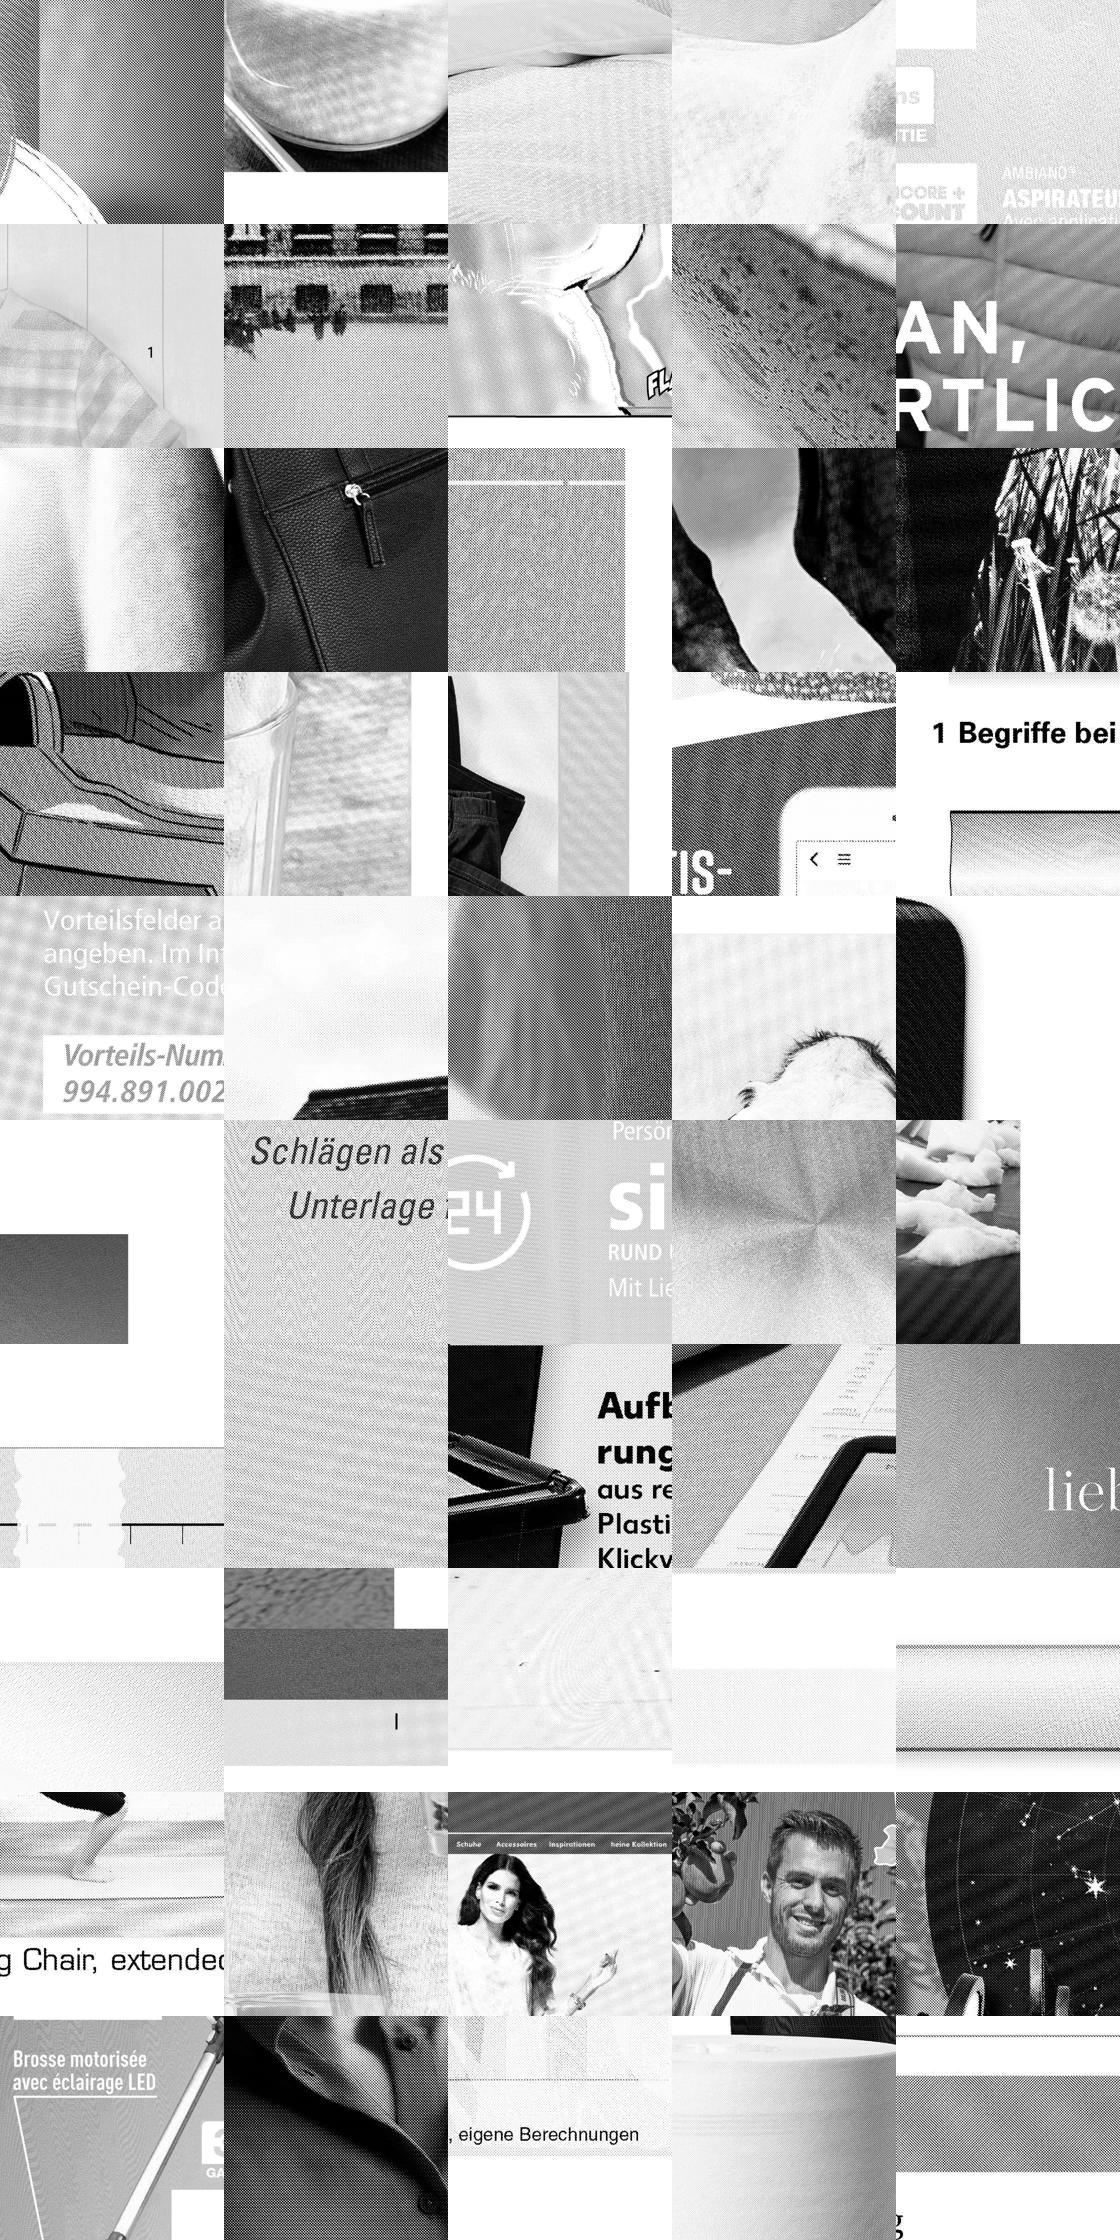

In [15]:
get_tile_result_grid( [sample[i] for i in range(len(sample)) if cluster_labels[i] == 1][:50] )